Regras: 

    JRIP

    Outro

Algoritmos:

    J48 / Árvore de decisão - X

    Random Forest - X

    RPTREE


    libsvm
    nayve bayes
    SVM - X
    Kmeans - X

# Preparação dos dados

In [ ]:
# Lendo drive
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# bibliotecas necessárias
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTE

## Lendo dados 

In [ ]:
# dados em pasta 
pasta = '/content/drive/My Drive/DEV PESQUISA /'

In [ ]:
# lendo dados
dados = pd.read_excel(pasta + 'base-completa_no_nulls.xlsx')

In [ ]:
dados.head()

,ID_MUNICIPIO,ID_AREA,ID_ESCOLA,ID_DEPENDENCIA_ADM,ID_LOCALIZACAO,ID_TURMA,CO_PROFESSOR,ID_SERIE,IN_PREENCHIMENTO_QUESTIONARIO,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,...,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,Código da Escola,Nome da Escola,IDEB2019
0,2704302.0,1.0,27034755.0,3.0,1.0,1176869.0,2.019198e+09,5.0,1.0,A,G,F,B,A,C,B,B,C,C,C,B,B,C,C,B,D,D,C,B,D,D,B,A,C,B,A,D,A,A,C,...,D,A,C,C,D,D,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,C,A,F,F,E,F,F,F,E,D,F,F,F,F,E,E,27034755,ESCOLA MUNICIPAL DOUTOR HENRIQUE EQUELMAN,6.1
1,2704302.0,1.0,27035441.0,3.0,1.0,1157326.0,2.019085e+09,5.0,1.0,A,F,D,A,A,C,B,C,C,C,C,C,C,B,C,C,C,B,B,C,C,C,D,C,B,B,B,B,D,D,C,...,C,B,C,B,B,C,B,C,A,A,A,A,B,A,A,A,A,A,E,E,E,E,E,F,F,E,E,F,F,F,F,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5
2,2704302.0,1.0,27035441.0,3.0,1.0,1180766.0,2.019085e+09,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,B,B,B,B,B,C,A,A,A,A,A,A,A,A,A,A,F,F,F,F,F,F,F,E,E,D,D,E,E,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5
3,2704302.0,1.0,27036049.0,3.0,1.0,1014439.0,2.019085e+09,5.0,1.0,A,E,E,A,A,D,B,C,B,C,B,B,C,C,D,C,C,B,B,B,B,B,D,C,C,B,C,C,A,C,A,...,C,A,B,C,D,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,E,E,F,F,E,E,E,F,E,F,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3
4,2704302.0,1.0,27036049.0,3.0,1.0,1169049.0,2.019116e+09,5.0,1.0,A,G,G,A,A,D,B,B,C,C,B,C,C,C,C,B,C,B,C,D,D,D,D,B,D,B,C,D,D,D,D,...,D,C,C,C,C,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,D,D,F,E,E,E,F,F,E,E,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3


In [ ]:
df_sobre_questoes = pd.read_excel(pasta + 'Consulta-descricao-questoes.xlsx')

In [ ]:
df_sobre_questoes.head()

,Código,cod,Descrição (texto da pergunta)
0,2,TX_RESP_Q001,Qual é a sua cor ou raça?
1,3,TX_RESP_Q002,Há quantos anos você trabalha como professor (a)?
2,4,TX_RESP_Q003,Há quantos anos você trabalha como professor(a...
3,5,TX_RESP_Q004,Em quantas escolas você trabalha?
4,6,TX_RESP_Q005,Qual o seu tipo de vínculo trabalhista nesta e...


## Criando função para coleta de informações sobre questões 

In [ ]:
# lendo dataframe com informacoes das questoes 
descricao_questoes_respostas = pd.read_csv(pasta + 'dicionario_questoes_respostas.csv')
descricao_questoes_respostas.head()

,questão,descrição,A,B,C,D,E,F,G
0,TX_RESP_Q001,Qual é a sua cor ou raça?,Branca.,Preta.,Parda.,Amarela.,Indígena.,Não quero declarar.,NaN
1,TX_RESP_Q002,Há quantos anos você trabalha como professor (a)?,Meu primeiro ano.,1-2 anos.,3-5 anos.,6-10 anos.,11-15 anos.,16-20 anos.,Mais de 20 anos.
2,TX_RESP_Q003,Há quantos anos você trabalha como professor(a...,Meu primeiro ano.,1-2 anos.,3-5 anos.,6-10 anos.,11-15 anos.,16-20 anos.,Mais de 20 anos.
3,TX_RESP_Q004,Em quantas escolas você trabalha?,Apenas nesta.,Em 2.,Em 3.,Em 4 ou mais.,NaN,NaN,NaN
4,TX_RESP_Q005,Qual o seu tipo de vínculo trabalhista nesta e...,Concursado/efetivo/estável.,Contrato temporário.,Contrato terceirizado.,Contrato CLT.,Pessoa jurídica.,Outra situação trabalhista.,NaN


In [ ]:
# funcao para obter texto da questao
def pegar_informacoes_questao(questao):
  try :
    informacoes = descricao_questoes_respostas[descricao_questoes_respostas['questão'] == questao]
  except NameError as e:
    raise NameError('Dataframe não encontrado')
  return informacoes

In [ ]:
# exemplo de uso da função
pegar_informacoes_questao('TX_RESP_Q001')

,questão,descrição,A,B,C,D,E,F,G
0,TX_RESP_Q001,Qual é a sua cor ou raça?,Branca.,Preta.,Parda.,Amarela.,Indígena.,Não quero declarar.,NaN


## Criando dataframe para classificação

Nesta etapa será criado duas classes para separar os resultados obtidos do IDEB


*   bom
    * Se o ideb for maior ou igual a 6.
*   ruim
    * Se o ideb for menor que 6.

Essas classes serão importantes para a construção dos algoritmos e pra análise de dados.



In [ ]:
dados.head()

,ID_MUNICIPIO,ID_AREA,ID_ESCOLA,ID_DEPENDENCIA_ADM,ID_LOCALIZACAO,ID_TURMA,CO_PROFESSOR,ID_SERIE,IN_PREENCHIMENTO_QUESTIONARIO,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,...,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,Código da Escola,Nome da Escola,IDEB2019
0,2704302.0,1.0,27034755.0,3.0,1.0,1176869.0,2.019198e+09,5.0,1.0,A,G,F,B,A,C,B,B,C,C,C,B,B,C,C,B,D,D,C,B,D,D,B,A,C,B,A,D,A,A,C,...,D,A,C,C,D,D,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,C,A,F,F,E,F,F,F,E,D,F,F,F,F,E,E,27034755,ESCOLA MUNICIPAL DOUTOR HENRIQUE EQUELMAN,6.1
1,2704302.0,1.0,27035441.0,3.0,1.0,1157326.0,2.019085e+09,5.0,1.0,A,F,D,A,A,C,B,C,C,C,C,C,C,B,C,C,C,B,B,C,C,C,D,C,B,B,B,B,D,D,C,...,C,B,C,B,B,C,B,C,A,A,A,A,B,A,A,A,A,A,E,E,E,E,E,F,F,E,E,F,F,F,F,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5
2,2704302.0,1.0,27035441.0,3.0,1.0,1180766.0,2.019085e+09,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,B,B,B,B,B,C,A,A,A,A,A,A,A,A,A,A,F,F,F,F,F,F,F,E,E,D,D,E,E,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5
3,2704302.0,1.0,27036049.0,3.0,1.0,1014439.0,2.019085e+09,5.0,1.0,A,E,E,A,A,D,B,C,B,C,B,B,C,C,D,C,C,B,B,B,B,B,D,C,C,B,C,C,A,C,A,...,C,A,B,C,D,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,E,E,F,F,E,E,E,F,E,F,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3
4,2704302.0,1.0,27036049.0,3.0,1.0,1169049.0,2.019116e+09,5.0,1.0,A,G,G,A,A,D,B,B,C,C,B,C,C,C,C,B,C,B,C,D,D,D,D,B,D,B,C,D,D,D,D,...,D,C,C,C,C,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,D,D,F,E,E,E,F,F,E,E,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3


In [ ]:
ideb_classes = []
for valor in dados['IDEB2019']:
  if valor >= 6:
    ideb_classes.append('bom')
  else:
    ideb_classes.append('ruim')
dados['classe'] = ideb_classes

In [ ]:
dados.head()

,ID_MUNICIPIO,ID_AREA,ID_ESCOLA,ID_DEPENDENCIA_ADM,ID_LOCALIZACAO,ID_TURMA,CO_PROFESSOR,ID_SERIE,IN_PREENCHIMENTO_QUESTIONARIO,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,...,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,Código da Escola,Nome da Escola,IDEB2019,classe
0,2704302.0,1.0,27034755.0,3.0,1.0,1176869.0,2.019198e+09,5.0,1.0,A,G,F,B,A,C,B,B,C,C,C,B,B,C,C,B,D,D,C,B,D,D,B,A,C,B,A,D,A,A,C,...,A,C,C,D,D,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,C,A,F,F,E,F,F,F,E,D,F,F,F,F,E,E,27034755,ESCOLA MUNICIPAL DOUTOR HENRIQUE EQUELMAN,6.1,bom
1,2704302.0,1.0,27035441.0,3.0,1.0,1157326.0,2.019085e+09,5.0,1.0,A,F,D,A,A,C,B,C,C,C,C,C,C,B,C,C,C,B,B,C,C,C,D,C,B,B,B,B,D,D,C,...,B,C,B,B,C,B,C,A,A,A,A,B,A,A,A,A,A,E,E,E,E,E,F,F,E,E,F,F,F,F,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5,ruim
2,2704302.0,1.0,27035441.0,3.0,1.0,1180766.0,2.019085e+09,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,B,B,B,B,B,C,A,A,A,A,A,A,A,A,A,A,F,F,F,F,F,F,F,E,E,D,D,E,E,F,F,F,F,F,F,27035441,ESCOLA DE ENSINO FUNDAMENTAL SAGRADO CORACAO D...,4.5,ruim
3,2704302.0,1.0,27036049.0,3.0,1.0,1014439.0,2.019085e+09,5.0,1.0,A,E,E,A,A,D,B,C,B,C,B,B,C,C,D,C,C,B,B,B,B,B,D,C,C,B,C,C,A,C,A,...,A,B,C,D,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,E,E,F,F,E,E,E,F,E,F,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3,bom
4,2704302.0,1.0,27036049.0,3.0,1.0,1169049.0,2.019116e+09,5.0,1.0,A,G,G,A,A,D,B,B,C,C,B,C,C,C,C,B,C,B,C,D,D,D,D,B,D,B,C,D,D,D,D,...,C,C,C,C,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,D,D,F,E,E,E,F,F,E,E,F,F,F,E,E,E,27036049,ESCOLA MUNICIPAL ZANELI CALDAS,6.3,bom


## Tratando dados

In [ ]:
# deixando apenas colunas uteis para analise de dados
dados_filtrados = dados.drop(columns=['ID_MUNICIPIO', 'ID_AREA', 'ID_ESCOLA', 'ID_DEPENDENCIA_ADM', 
                                      'ID_TURMA', 'CO_PROFESSOR', 'IN_PREENCHIMENTO_QUESTIONARIO', 'Código da Escola',
                                      'Código da Escola', 'Nome da Escola'])
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,A,G,F,B,A,C,B,B,C,C,C,B,B,C,C,B,D,D,C,B,D,D,B,A,C,B,A,D,A,A,C,C,D,C,A,A,B,A,...,C,D,A,C,C,D,D,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,C,A,F,F,E,F,F,F,E,D,F,F,F,F,E,E,6.1,bom
1,1.0,5.0,A,F,D,A,A,C,B,C,C,C,C,C,C,B,C,C,C,B,B,C,C,C,D,C,B,B,B,B,D,D,C,D,E,E,D,C,C,C,...,C,C,B,C,B,B,C,B,C,A,A,A,A,B,A,A,A,A,A,E,E,E,E,E,F,F,E,E,F,F,F,F,F,F,F,F,F,F,4.5,ruim
2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,B,B,B,B,B,C,A,A,A,A,A,A,A,A,A,A,F,F,F,F,F,F,F,E,E,D,D,E,E,F,F,F,F,F,F,4.5,ruim
3,1.0,5.0,A,E,E,A,A,D,B,C,B,C,B,B,C,C,D,C,C,B,B,B,B,B,D,C,C,B,C,C,A,C,A,C,E,E,A,C,D,B,...,C,C,A,B,C,D,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,E,E,F,F,E,E,E,F,E,F,F,F,F,E,E,E,6.3,bom
4,1.0,5.0,A,G,G,A,A,D,B,B,C,C,B,C,C,C,C,B,C,B,C,D,D,D,D,B,D,B,C,D,D,D,D,D,E,E,A,E,E,D,...,D,D,C,C,C,C,C,C,C,A,A,A,A,A,A,A,A,A,A,F,F,E,D,D,F,E,E,E,F,F,E,E,F,F,F,E,E,E,6.3,bom


### Transformando dados categoricos em numericos

In [ ]:
# script para ver todos os dados categoricos que aparecem nas colunas das questoes 
# Obs: existem valores nan nos dados

dados_categoricos = []
for coluna in dados_filtrados.columns:
  if coluna not in ['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019', 'classe']:
    for dado in dados_filtrados[coluna]:
      if dado not in dados_categoricos:
        dados_categoricos.append(dado)
dados_categoricos

['A', nan, 'C', 'B', 'D', 'F', 'G', 'E']

In [ ]:
type(dados_categoricos[1])

float

In [ ]:
# organizando valores de dados_categoricos
dados_categoricos.pop(1) # removendo nan
dados_categoricos.sort() # ordenando valores

In [ ]:
# mostrando a representacao dos valores categoricos em numericos 
dados_numericos = list(range(len(dados_categoricos)))
for c in range(len(dados_categoricos)):
    print(dados_categoricos[c], '=', dados_numericos[c])

A = 0
B = 1
C = 2
D = 3
E = 4
F = 5
G = 6


In [ ]:
# trocando o tipo do atributo diagnostico por um tipo numerico
for coluna in dados_filtrados.columns:
  if coluna not in ['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019']:
    dados_filtrados[coluna] = dados_filtrados[coluna].replace(dados_categoricos, dados_numericos)
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4,6.1,bom
1,1.0,5.0,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,4.5,ruim
2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5,4.5,ruim
3,1.0,5.0,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,...,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4,6.3,bom
4,1.0,5.0,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4,6.3,bom


In [ ]:
# transformando classe categórica em numérica
dados_filtrados['classe'] = dados_filtrados['classe'].replace(['bom', 'ruim'], [1, 0])
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4,6.1,1
1,1.0,5.0,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
3,1.0,5.0,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,...,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
4,1.0,5.0,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1


### Tratando valores nan

In [ ]:
# checando se existem valores vazios nas colunas do dataset
dados_filtrados.isna().any()

ID_LOCALIZACAO     True
ID_SERIE           True
TX_RESP_Q001       True
TX_RESP_Q002       True
TX_RESP_Q003       True
                  ...  
TX_RESP_Q126       True
TX_RESP_Q127       True
TX_RESP_Q128      False
IDEB2019          False
classe            False
Length: 132, dtype: bool

In [ ]:
# quantas linhas e colunas existem antes de remover nan dados
print('Linhas: ', dados_filtrados.shape[0])
print('Colunas: ', dados_filtrados.shape[1])

Linhas:  350
Colunas:  132


In [ ]:
# antes de remover, guardando valores nan para analise
nan_values = dados_filtrados[dados_filtrados.isna().any(axis=1)]

In [ ]:
# removendo linhas com dados nan
dados_filtrados = dados_filtrados.dropna(how='any',axis=0) 

In [ ]:
# quantas linhas e colunas existem após remover nan dados
print('Linhas: ', dados_filtrados.shape[0])
print('Colunas: ', dados_filtrados.shape[1])

Linhas:  192
Colunas:  132


### Analisando instâncias com valores nan

In [ ]:
# mostrando instâncias com nan
nan_values.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
8,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4.4,0
10,1.0,5.0,1.0,6.0,4.0,1.0,0.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,NaN,1.0,3.0,3.0,3.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,3.0,4.0,3.0,0.0,0.0,2.0,2.0,...,3.0,3.0,1.0,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,3.0,5.0,4.0,3.0,2.0,5.0,2.0,5.0,1.0,0.0,5,4.4,0
11,1.0,5.0,2.0,6.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,3.0,2.0,2.0,3.0,3.0,3.0,4.0,2.0,1.0,2.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,5.0,0
18,1.0,5.0,1.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,3.0,NaN,2.0,1.0,1.0,1.0,...,3.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,3.0,5.0,5.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4,5.9,0


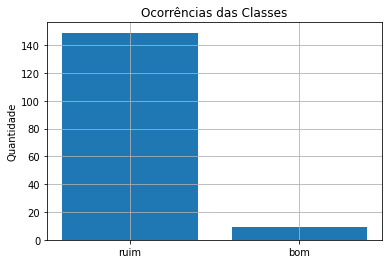

ruim: 149 | bom: 9


In [ ]:
# verificando balanceamento de classe de nan 

classes = nan_values.groupby(by=['classe'])['classe'].count()

plt.bar(['ruim', 'bom'], [classes[0], classes[1]])
plt.ylabel('Quantidade')
plt.title('Ocorrências das Classes')
plt.grid(True)
plt.show()

print('ruim: {} | bom: {}'.format(classes[0], classes[1]))


### Observações sobre tratamento de dados

Foram 158 instâncias apagas ao remover valores nan, quase a metáde do número de instâncias do dataframe. Tendo isso em vista, é recomendável fazer testes com outros métodos para remover os valores nan e manter as instâncias, para que assim seja possível observar como os modelos de previsão irão se comportar com ao utilizar a outra parte dos dados. 

## Criando dataframe para contagem de ocorrências em questões

O dataframe criado nessa secção terá a ocorrência de vezes que cada alternativa foi marcada em cada questão.

In [ ]:
# gera novo dataframe com as colunas mas nenhuma instância
colunas = ['questão', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
questoes_contagem = pd.DataFrame(columns=colunas)

# variável para comparação entre numero e letra 
categoricos = { c:valor for c, valor in enumerate(colunas[1:])}

# percorre todas as questões no dataset dados_filtrados
for coluna in dados_filtrados.drop(columns=['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019']):
  
  # prepara nova linha que será adicionada ao dataframe criado
  nova_linha = { c:0 for c in colunas}
  nova_linha['questão'] = coluna

  # conta a ocorrência de vezes que certa letra apareceu para certa questão
  contagem = { c:0 for c in range(7) }
  for valor in dados_filtrados[coluna]:
    contagem[valor] += 1
  
  # percorre dicionário com contagem e transforma os valores e passa para a variável nova_linha
  for chave_numerica in contagem:

    chave_categorica = categoricos[chave_numerica]
    valor = contagem[chave_numerica]

    nova_linha[chave_categorica] = valor
  
  # adiciona nova linha ao dataframe criado
  questoes_contagem = questoes_contagem.append(nova_linha, ignore_index=True)

In [ ]:
# dataframe gerado
questoes_contagem

,questão,A,B,C,D,E,F,G
0,TX_RESP_Q001,60,23,106,3,0,0,0
1,TX_RESP_Q002,7,8,9,29,38,36,65
2,TX_RESP_Q003,11,18,21,37,47,24,34
3,TX_RESP_Q004,85,95,10,2,0,0,0
4,TX_RESP_Q005,179,12,0,0,0,1,0
...,...,...,...,...,...,...,...,...
124,TX_RESP_Q125,0,0,1,2,73,116,0
125,TX_RESP_Q126,3,0,8,34,101,46,0
126,TX_RESP_Q127,0,0,0,12,87,93,0
127,TX_RESP_Q128,0,0,2,24,102,64,0


# Técnicas de Seleção de Features

In [ ]:
# variável que guardará as questoes escolhidas pelas técnicas de seleção
questoes_selecionadas = []

## Analisando Correlação

### Ánalise de correlação

In [ ]:
# tabela de correlação
dados_filtrados.corr()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
ID_LOCALIZACAO,1.000000,-0.012996,0.057102,0.028580,0.059991,-0.072126,-0.014900,-0.021749,0.034517,0.058103,0.011372,0.059271,-0.024406,0.003988,0.121044,-0.007994,-0.178531,-0.076018,-0.123806,-0.088075,-0.032446,0.014698,0.061624,-0.037704,0.042881,0.093988,-0.009477,0.057932,0.062954,0.054946,-0.019750,0.057618,-0.006703,0.049979,-0.076932,0.068694,0.029194,0.036142,-0.104104,0.109957,...,0.095295,0.087494,0.089796,0.005408,0.008613,0.125410,0.101156,0.023167,0.003953,NaN,-0.012996,-0.010554,-0.016046,-0.016046,-0.009116,NaN,-0.005236,-0.005236,-0.019791,0.036884,-0.098218,-0.001140,0.010652,0.005518,-0.139112,-0.039453,0.016086,-0.048513,-0.043534,-0.137888,-0.114994,-0.085536,-0.085161,-0.077153,-0.077694,-0.072963,-0.169392,-0.126027,-0.148099,-0.024674
ID_SERIE,-0.012996,1.000000,0.141738,0.052781,0.131707,0.105052,-0.036986,-0.251416,0.262562,0.069180,-0.072140,-0.032227,0.064488,-0.116801,-0.166271,-0.019842,0.052682,-0.019793,0.095719,-0.006625,-0.080537,-0.096944,-0.035299,-0.020544,0.047204,0.020756,0.096922,0.205154,0.098788,-0.113007,0.010175,0.081173,-0.016637,0.061044,0.014442,0.095252,0.111770,0.168364,0.109105,0.116972,...,-0.126061,-0.053589,-0.068232,0.013424,-0.083873,-0.171682,-0.198413,-0.165546,-0.304199,NaN,0.311828,-0.026198,-0.039830,-0.039830,-0.022628,NaN,-0.012996,-0.012996,0.100588,-0.263563,-0.454646,-0.274400,-0.098905,0.133229,-0.214537,-0.026708,0.151038,-0.120418,-0.274708,-0.259915,-0.169817,-0.144713,0.129674,0.133887,0.137751,0.214037,0.170958,-0.137203,-0.191227,-0.061245
TX_RESP_Q001,0.057102,0.141738,1.000000,0.047380,0.145840,-0.024704,-0.034141,-0.050926,0.048228,-0.132038,-0.048432,-0.224272,-0.028213,0.004225,-0.133664,-0.069171,0.033068,-0.109164,0.006957,0.095643,-0.010111,0.178889,-0.025111,0.094852,0.051009,0.010527,0.052332,0.009387,0.060205,-0.192256,-0.013122,0.023778,0.094208,-0.005191,0.123491,0.079867,0.029451,0.020519,0.024270,0.052619,...,-0.091930,-0.078960,0.007424,0.011797,0.064621,0.019184,0.060618,0.072848,-0.087465,NaN,0.012149,-0.042756,0.068337,-0.038335,-0.173284,NaN,-0.099520,-0.099520,0.032597,0.090903,-0.060385,-0.081326,-0.068967,-0.146465,-0.046427,0.094999,0.044243,0.022158,-0.011604,-0.054598,-0.019504,-0.072801,0.051067,0.106167,0.100300,0.088878,0.046984,0.117815,-0.018534,-0.007689
TX_RESP_Q002,0.028580,0.052781,0.047380,1.000000,0.037520,-0.091084,-0.058296,0.061411,0.016970,0.007612,-0.125651,-0.006434,0.001203,0.031730,0.058557,-0.126505,-0.176922,-0.146650,-0.166543,-0.186837,0.009352,-0.094320,-0.092948,-0.125740,-0.180931,-0.103606,0.035842,0.017305,-0.043324,-0.155148,-0.032791,0.060865,-0.046232,-0.026711,-0.008272,0.117577,0.016963,0.051783,0.053175,0.037729,...,-0.051310,0.017814,-0.021528,0.078176,0.025201,-0.060045,0.070588,0.032467,-0.029867,NaN,0.016458,0.079739,-0.106749,0.012847,0.075243,NaN,0.072479,0.072479,-0.050004,0.145407,0.024228,0.058778,-0.011836,-0.107932,-0.130956,0.049965,0.167287,0.136663,0.088118,0.065966,0.

In [ ]:
# Vendo se existem valores nan na correlação
dados_filtrados.corr().isna().any()

ID_LOCALIZACAO    True
ID_SERIE          True
TX_RESP_Q001      True
TX_RESP_Q002      True
TX_RESP_Q003      True
                  ... 
TX_RESP_Q126      True
TX_RESP_Q127      True
TX_RESP_Q128      True
IDEB2019          True
classe            True
Length: 132, dtype: bool

**Sobre valores nan na correlação**

A forma que se é cálculado os coeficientes de correlação abre margem para a possibildade de divisão por 0, tendo isso em mente o valor retornado para superar esse problema é o valor nan.

O valor nan pode ser interpretado como: Não existem correlação entre as variáveis analisádas.

Fontes: 
  * https://www.mathworks.com/matlabcentral/answers/506464-getting-a-nan-in-correlation-coefficient

In [ ]:
# correlacoes apenas das questões com o valor do ideb
correlacoes_ideb = dados_filtrados[dados_filtrados.columns[3:]]
correlacoes_ideb = correlacoes_ideb.drop(columns=['classe']).corr()['IDEB2019']
correlacoes_ideb

TX_RESP_Q002    0.198131
TX_RESP_Q003   -0.189862
TX_RESP_Q004   -0.003893
TX_RESP_Q005   -0.078519
TX_RESP_Q006    0.105983
                  ...   
TX_RESP_Q125    0.024551
TX_RESP_Q126   -0.041079
TX_RESP_Q127   -0.018304
TX_RESP_Q128    0.015567
IDEB2019        1.000000
Name: IDEB2019, Length: 128, dtype: float64

In [ ]:
# mostrando colunas com nan e as substituindo por 0
print('Correlações nan:')
print()
c = 0
for valor in correlacoes_ideb.isna():
  if valor is True:
    print(correlacoes_ideb.index[c], '-', 'nan')
    correlacoes_ideb[correlacoes_ideb.index[c]] = 0
    print(correlacoes_ideb.index[c], '-', correlacoes_ideb[correlacoes_ideb.index[c]])
    print()
  c += 1

Correlações nan:

TX_RESP_Q100 - nan
TX_RESP_Q100 - 0.0

TX_RESP_Q106 - nan
TX_RESP_Q106 - 0.0



In [ ]:
# ordenando correlacao
correlacoes_ideb = correlacoes_ideb.sort_values(ascending=False)
correlacoes_ideb

IDEB2019        1.000000
TX_RESP_Q002    0.198131
TX_RESP_Q037    0.159338
TX_RESP_Q098    0.145883
TX_RESP_Q060    0.140370
                  ...   
TX_RESP_Q024   -0.106555
TX_RESP_Q072   -0.108165
TX_RESP_Q101   -0.117424
TX_RESP_Q029   -0.133346
TX_RESP_Q003   -0.189862
Name: IDEB2019, Length: 128, dtype: float64

Os 20 com correlação mais forte (menos a coluna do ideb consigo mesma):
Index(['TX_RESP_Q002', 'TX_RESP_Q037', 'TX_RESP_Q098', 'TX_RESP_Q060',
       'TX_RESP_Q092', 'TX_RESP_Q097', 'TX_RESP_Q122', 'TX_RESP_Q034',
       'TX_RESP_Q019', 'TX_RESP_Q085', 'TX_RESP_Q028', 'TX_RESP_Q095',
       'TX_RESP_Q111', 'TX_RESP_Q091', 'TX_RESP_Q006', 'TX_RESP_Q120',
       'TX_RESP_Q036', 'TX_RESP_Q087', 'TX_RESP_Q124', 'TX_RESP_Q058'],
      dtype='object')


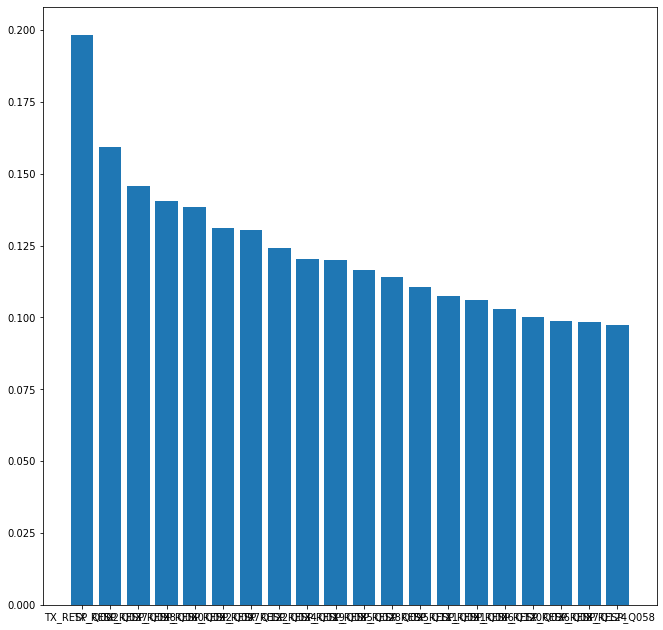

In [ ]:
# mostrando os 20 com correlação mais forte
print('Os 20 com correlação mais forte (menos a coluna do ideb consigo mesma):')
print(correlacoes_ideb.index[1:21])
plt.rcParams["figure.figsize"] = (11, 11)
plt.bar(correlacoes_ideb.index[1:21], correlacoes_ideb.values[1:21])
plt.show()

Os 20 com correlação mais fraca ou inversa:
Index(['TX_RESP_Q003', 'TX_RESP_Q029', 'TX_RESP_Q101', 'TX_RESP_Q072',
       'TX_RESP_Q024', 'TX_RESP_Q023', 'TX_RESP_Q043', 'TX_RESP_Q113',
       'TX_RESP_Q005', 'TX_RESP_Q109', 'TX_RESP_Q047', 'TX_RESP_Q009',
       'TX_RESP_Q008', 'TX_RESP_Q093', 'TX_RESP_Q053', 'TX_RESP_Q044',
       'TX_RESP_Q042', 'TX_RESP_Q112', 'TX_RESP_Q014', 'TX_RESP_Q011'],
      dtype='object')


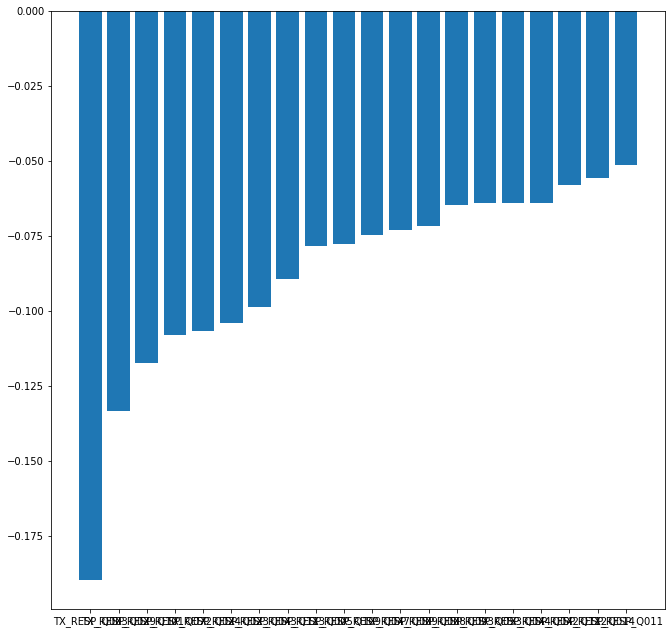

In [ ]:
# mostrando os 20 com correlação mais fraca ou inversa
print('Os 20 com correlação mais fraca ou inversa:')
print(correlacoes_ideb.index[-1:-21:-1])
plt.rcParams["figure.figsize"] = (11, 11)
plt.bar(correlacoes_ideb.index[-1:-21:-1], correlacoes_ideb.values[-1:-21:-1])
plt.show()

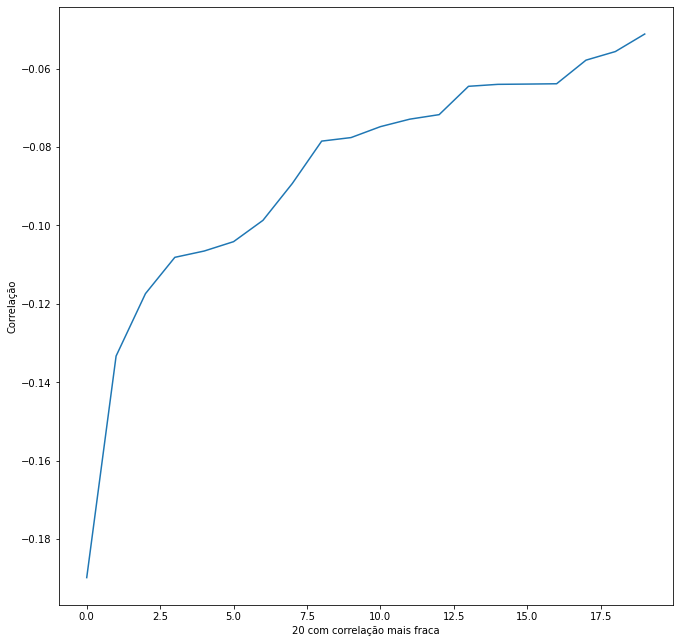

In [ ]:
plt.plot(correlacoes_ideb.values[-1:-21:-1])
plt.ylabel('Correlação')
plt.xlabel('20 com correlação mais fraca')
plt.show()

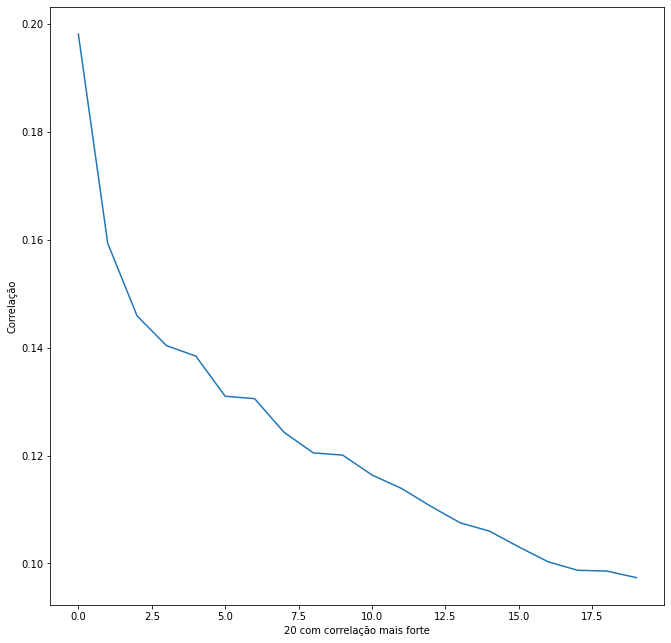

In [ ]:
plt.plot(correlacoes_ideb.values[1:21])
plt.ylabel('Correlação')
plt.xlabel('20 com correlação mais forte')
plt.show()

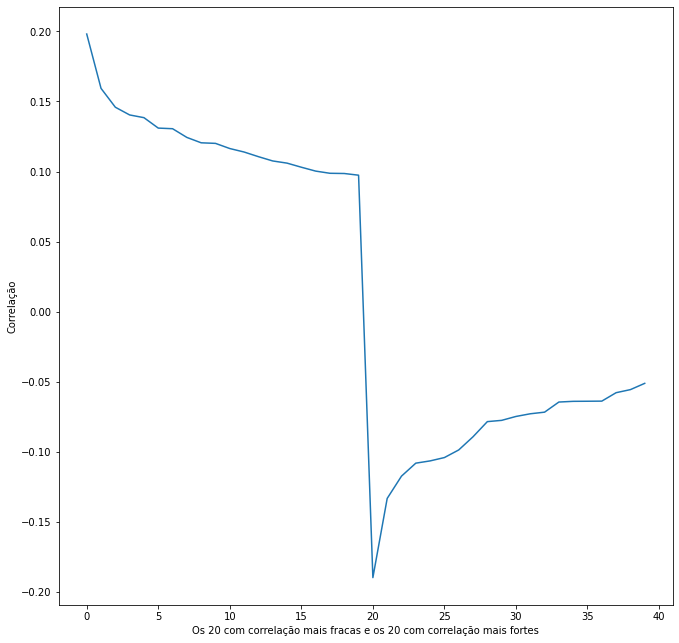

In [ ]:
# plotando gráfico dos 20 com correlação mais forte e dos 20 com correlação mais fraca
plt.plot(list(correlacoes_ideb.values[1:21]) + list(correlacoes_ideb.values[-1:-21:-1]))
plt.ylabel('Correlação')
plt.xlabel('Os 20 com correlação mais fracas e os 20 com correlação mais fortes')
plt.show()

### Conclusão da análise de correlação

O critério para a seleção de uma coluna para a criação dos modelo será pela comparação de seu valor de correlação, se for um valor superior a 0.1 ou inferior a -0.1 essas colunas serão selecionadas.

In [ ]:
print('Colunas selecionadas com correlação positiva:')
print('Coluna | Correlação')
for coluna in correlacoes_ideb.index[1:18]:
  print(coluna, '|', correlacoes_ideb[coluna])

Colunas selecionadas com correlação positiva:
Coluna | Correlação
TX_RESP_Q002 | 0.19813084839287962
TX_RESP_Q037 | 0.15933753932919467
TX_RESP_Q098 | 0.14588276769188918
TX_RESP_Q060 | 0.14036977974185136
TX_RESP_Q092 | 0.13842838642522054
TX_RESP_Q097 | 0.13098603635508366
TX_RESP_Q122 | 0.13054396249472364
TX_RESP_Q034 | 0.12432532595340841
TX_RESP_Q019 | 0.12048702015429412
TX_RESP_Q085 | 0.12007825374477521
TX_RESP_Q028 | 0.11639381193637703
TX_RESP_Q095 | 0.11390760114756802
TX_RESP_Q111 | 0.11059294460942028
TX_RESP_Q091 | 0.10753026319948343
TX_RESP_Q006 | 0.10598337217750853
TX_RESP_Q120 | 0.10305549003250757
TX_RESP_Q036 | 0.10029157841924133


In [ ]:
print('Colunas selecionadas com correlação negativa:')
print('Coluna | Correlação')
for coluna in correlacoes_ideb.index[-1:-7:-1]:
  print(coluna, '|', correlacoes_ideb[coluna])

Colunas selecionadas com correlação negativa:
Coluna | Correlação
TX_RESP_Q003 | -0.1898621205764164
TX_RESP_Q029 | -0.13334574122514764
TX_RESP_Q101 | -0.11742446172818549
TX_RESP_Q072 | -0.10816514313981439
TX_RESP_Q024 | -0.10655524678922504
TX_RESP_Q023 | -0.10416737584141475


#### Mostrando questões selecionadas




In [ ]:
# mostrando questões com correlação positiva
for coluna in correlacoes_ideb.index[1:18]:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q002
------------------------------
Há quantos anos você trabalha como professor (a)?
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q037
------------------------------
INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA NESTA ESCOLA E QUAL A SUA ADEQUAÇÃO PARA AS ATIVIDADES EM SALA DE AULA: - Internet
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q098
------------------------------
INDIQUE O QUANTO VOCÊ CONCORDA OU DISCORDA EM RELAÇÃO AOS SEGUINTES TEMAS ENVOLVENDO SEUS(SUAS) ALUNOS(AS) NESTA ESCOLA: - São respeitosos(as) com os(as) colegas da turma
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q060
------------------------------
DURANTE ESTE ANO, INDIQUE DE QUAIS CURSOS DE PÓS-GRADUAÇÃO VOCÊ PARTICIPOU E SE RECEBEU APOIO DA SECRETARIA OU MANTENEDORA PARA REALIZÁ-LO: - Mestrado (acadêmico ou profissional)
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q092


In [ ]:
# mostrando tabela com informações das questões com correlação positiva
resultados_positivos = []
for coluna in correlacoes_ideb.index[1:18]:
  resultados_positivos.append(pegar_informacoes_questao(coluna))
  resultados_positivos.append(questoes_contagem[questoes_contagem['questão'] == coluna])
pd.concat(resultados_positivos)

,questão,descrição,A,B,C,D,E,F,G
1,TX_RESP_Q002,Há quantos anos você trabalha como professor (a)?,Meu primeiro ano.,1-2 anos.,3-5 anos.,6-10 anos.,11-15 anos.,16-20 anos.,Mais de 20 anos.
1,TX_RESP_Q002,NaN,7,8,9,29,38,36,65
36,TX_RESP_Q037,INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA N...,NÃO USO / Não tem.,USO E É Inadequado.,USO E É Pouco adequado.,USO E É Razoavelmente adequado.,USO E É Adequado.,NaN,NaN
36,TX_RESP_Q037,NaN,47,17,35,54,39,0,0
97,TX_RESP_Q098,INDIQUE O QUANTO VOCÊ CONCORDA OU DISCORDA EM ...,Discordo fortemente.,Discordo.,Concordo.,Concordo fortemente.,NaN,NaN,NaN
97,TX_RESP_Q098,NaN,0,47,131,14,0,0,0
59,TX_RESP_Q060,"DURANTE ESTE ANO, INDIQUE DE QUAIS CURSOS DE P...",Não fiz este curso.,"Sim, sem apoio.","Sim, com apoio parcial.","Sim, com apoio total.",NaN,NaN,NaN
59,TX_RESP_Q060,NaN,186,6,0,0,0,0,0
91,TX_RESP_Q092,"NESTA ESCOLA E NESTE ANO, INDIQUE A FREQUÊNCIA...",Nunca.,Poucas vezes.,Muitas vezes.,Sempre.,NaN,NaN,NaN
91,TX_RESP_Q092,NaN,2,21,106,63,0,0,0


In [ ]:
# mostrando questões com correlação negativa
for coluna in correlacoes_ideb.index[-1:-7:-1]:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q003
------------------------------
Há quantos anos você trabalha como professor(a) nesta escola?
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q029
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Acessibilidade
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q101
------------------------------
SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQUÊNCIA COM QUE OCORRERAM NESTA ESCOLA E NESTE ANO: - Os(As) alunos(as) frequentaram a escola sob efeito de drogas ilícitas
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q072
------------------------------
NESTE ANO, INDIQUE O PRINCIPAL RESPONSÁVEL PELAS SEGUINTES DEFINIÇÕES: - Instrumentos para avaliar os(as) alunos(as)
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q024
------------------------------
AVALIE AS CONDIÇÕES DA SALA D

In [ ]:
# mostrando tabela com informações das questões com correlação negativas
resultados_negativos = []
for coluna in correlacoes_ideb.index[-1:-7:-1]:
  resultados_negativos.append(pegar_informacoes_questao(coluna))
  resultados_negativos.append(questoes_contagem[questoes_contagem['questão'] == coluna])

pd.concat(resultados_negativos)

,questão,descrição,A,B,C,D,E,F,G
2,TX_RESP_Q003,Há quantos anos você trabalha como professor(a...,Meu primeiro ano.,1-2 anos.,3-5 anos.,6-10 anos.,11-15 anos.,16-20 anos.,Mais de 20 anos.
2,TX_RESP_Q003,NaN,11,18,21,37,47,24,34
28,TX_RESP_Q029,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
28,TX_RESP_Q029,NaN,20,19,41,112,0,0,0
100,TX_RESP_Q101,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
100,TX_RESP_Q101,NaN,186,6,0,0,0,0,0
71,TX_RESP_Q072,"NESTE ANO, INDIQUE O PRINCIPAL RESPONSÁVEL PEL...",Docente da turma.,Todo o corpo docente da escola.,Equipe gestora.,Decisão externa à escola (Secretaria de Educaç...,NaN,NaN,NaN
71,TX_RESP_Q072,NaN,75,86,20,11,0,0,0
23,TX_RESP_Q024,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
23,TX_RESP_Q024,NaN,48,43,51,50,0,0,0


In [ ]:
# salvando resultados
questoes_selecionadas.append(list(correlacoes_ideb.index[1:18]) + list(correlacoes_ideb.index[-1:-7:-1]))

## Teste Symmetrical *Uncertainty* (SU)

In [ ]:
# Biblioteca usada para symmetrical uncertainty

!pip install ITMO_FS

     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 276kB 13.5MB/s 
  Created wheel for quadprog: filename=quadprog-0.1.8-cp37-cp37m-linux_x86_64.whl size=336650 sha256=8f1446b3d4980afcafa687315f90464f1aeeae921a149a5714342348458891ec
  Stored in directory: /root/.cache/pip/wheels/0c/39/5f/c712b0e462439dec9b30080cf34622f167929b39bd964d8baf
Successfully built quadprog


In [ ]:
# importando 
import ITMO_FS

In [ ]:
# Mostrando dados 
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4,6.1,1
1,1.0,5.0,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
3,1.0,5.0,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,...,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
4,1.0,5.0,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
5,1.0,5.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,...,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4,6.3,1


In [ ]:
# selecionando features
x = dados_filtrados.drop(columns=['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019', 'classe'])
y = dados_filtrados['classe']

In [ ]:
# mostrando x
x.head()

,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,TX_RESP_Q039,TX_RESP_Q040,...,TX_RESP_Q089,TX_RESP_Q090,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128
0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,3.0,2.0,...,1.0,2.0,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4
1,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5
3,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,0.0,1.0,...,1.0,1.0,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4
4,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4
5,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,3.0,4.0,...,1.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4


In [ ]:
# mostrando y
y

0      1
1      0
3      1
4      1
5      1
      ..
337    0
338    0
339    0
348    0
349    0
Name: classe, Length: 192, dtype: int64

In [ ]:
# gerando array de scores
scores = ITMO_FS.filters.univariate.su_measure(x.values, y.values)
scores

array([0.25231736, 0.17534526, 0.16283011, 0.27398561, 0.56961852,
       0.27754693, 0.25441724, 0.22499283, 0.27834119, 0.25316213,
       0.34413628, 0.34465764, 0.27343293, 0.2710611 , 0.27969648,
       0.25317685, 0.24440075, 0.2399599 , 0.26921165, 0.21829551,
       0.27178904, 0.25695115, 0.27347703, 0.20333341, 0.21944016,
       0.20478042, 0.21379342, 0.26753787, 0.25776509, 0.23435252,
       0.22102593, 0.24005274, 0.31812331, 0.1962252 , 0.20592144,
       0.2122538 , 0.2021315 , 0.18679416, 0.22626839, 0.20936397,
       0.2183946 , 0.38609537, 0.3092834 , 0.321523  , 0.38317189,
       0.41054349, 0.22176111, 0.2575552 , 0.35531913, 0.33079714,
       0.23892626, 0.30617891, 0.21335218, 0.21563501, 0.29292107,
       0.21265139, 0.20522524, 0.22060797, 0.35220998, 0.71933786,
       0.76070122, 0.24948934, 0.24801756, 0.23841657, 0.21010331,
       0.2298229 , 0.24575329, 0.2075316 , 0.20208719, 0.21643337,
       0.22675442, 0.23334922, 0.21428461, 0.3141934 , 0.43670

In [ ]:
# juntando resultado com sua questão
resultados_su = []
for position in range(len(scores)):
  resultados_su.append((x.columns[position], scores[position]))
resultados_su

[('TX_RESP_Q001', 0.2523173634073762),
 ('TX_RESP_Q002', 0.17534526263865124),
 ('TX_RESP_Q003', 0.16283011167785014),
 ('TX_RESP_Q004', 0.273985606914783),
 ('TX_RESP_Q005', 0.5696185220038171),
 ('TX_RESP_Q006', 0.27754692785321466),
 ('TX_RESP_Q007', 0.2544172421358954),
 ('TX_RESP_Q008', 0.2249928276834896),
 ('TX_RESP_Q009', 0.278341193540641),
 ('TX_RESP_Q010', 0.2531621273119508),
 ('TX_RESP_Q011', 0.34413628241599487),
 ('TX_RESP_Q012', 0.34465764115451825),
 ('TX_RESP_Q013', 0.2734329318557892),
 ('TX_RESP_Q014', 0.27106110095092556),
 ('TX_RESP_Q015', 0.2796964797445494),
 ('TX_RESP_Q016', 0.2531768523793119),
 ('TX_RESP_Q017', 0.24440074540845244),
 ('TX_RESP_Q018', 0.23995989618417135),
 ('TX_RESP_Q019', 0.2692116521778382),
 ('TX_RESP_Q020', 0.21829551376756554),
 ('TX_RESP_Q021', 0.27178903605501253),
 ('TX_RESP_Q022', 0.25695115231724847),
 ('TX_RESP_Q023', 0.2734770300906606),
 ('TX_RESP_Q024', 0.20333340786453036),
 ('TX_RESP_Q025', 0.21944015763426425),
 ('TX_RESP_Q02

In [ ]:
# shell sort para ordenar lista de nx2 dimensões
def shell_sort(lista):
    h = 1
    while h<len(lista):
            if 3*h+1 < len(lista):
                    h = 3*h+1
            else:
                    break
    while h!=1:
            h = h//2
            for i in range(h,len(lista)):
                    aux = lista[i]
                    j = i
                    while lista[j-h][1]>aux[1]:
                            lista[j] = lista[j-h]
                            j-=h
                            if j<h:
                                    break
                    lista[j] = aux
    return lista	

In [ ]:
# ordenando resultados (ordem do menor para maior)
shell_sort(resultados_su)
resultados_su

[('TX_RESP_Q003', 0.16283011167785014),
 ('TX_RESP_Q002', 0.17534526263865124),
 ('TX_RESP_Q038', 0.18679416451243094),
 ('TX_RESP_Q034', 0.19622519516123493),
 ('TX_RESP_Q069', 0.20208718692716668),
 ('TX_RESP_Q037', 0.20213150368968527),
 ('TX_RESP_Q024', 0.20333340786453036),
 ('TX_RESP_Q080', 0.20340878353395883),
 ('TX_RESP_Q026', 0.20478042372608612),
 ('TX_RESP_Q057', 0.20522524168154976),
 ('TX_RESP_Q113', 0.20538860578618487),
 ('TX_RESP_Q035', 0.20592144413983182),
 ('TX_RESP_Q114', 0.20592299807431375),
 ('TX_RESP_Q068', 0.20753159572604418),
 ('TX_RESP_Q040', 0.2093639656496386),
 ('TX_RESP_Q065', 0.21010330843249997),
 ('TX_RESP_Q036', 0.21225380114918796),
 ('TX_RESP_Q056', 0.212651385215716),
 ('TX_RESP_Q053', 0.21335218483565002),
 ('TX_RESP_Q027', 0.21379341911213867),
 ('TX_RESP_Q118', 0.2140615462771266),
 ('TX_RESP_Q121', 0.21407802741568877),
 ('TX_RESP_Q073', 0.21428460848068479),
 ('TX_RESP_Q054', 0.21563500723330328),
 ('TX_RESP_Q117', 0.21627693472392728),
 ('T

### Conclusão do Teste Symmetrical Uncertainty  



Como o Symmetrical Uncertainty é um teste de correlação, serão escolhidas 20 questões com um maior índice de correlação sobre o ideb ser bom ou ruim (coluna "classe").

In [ ]:
# questões escolhidas
su_escolhidos = resultados_su[-1:-21:-1]
su_escolhidos

[('TX_RESP_Q106', 1.0),
 ('TX_RESP_Q100', 1.0),
 ('TX_RESP_Q107', 0.9127317789950639),
 ('TX_RESP_Q108', 0.9127317789950639),
 ('TX_RESP_Q105', 0.8100663944406156),
 ('TX_RESP_Q102', 0.7727473775314898),
 ('TX_RESP_Q061', 0.7607012177252706),
 ('TX_RESP_Q060', 0.7193378631168547),
 ('TX_RESP_Q101', 0.7135160997108425),
 ('TX_RESP_Q103', 0.6485718356389284),
 ('TX_RESP_Q104', 0.6485718356389284),
 ('TX_RESP_Q079', 0.6383643739807889),
 ('TX_RESP_Q078', 0.613590660294556),
 ('TX_RESP_Q077', 0.5926034115191832),
 ('TX_RESP_Q005', 0.5696185220038171),
 ('TX_RESP_Q109', 0.5108910707901746),
 ('TX_RESP_Q115', 0.49420060594849513),
 ('TX_RESP_Q076', 0.44510990503087483),
 ('TX_RESP_Q075', 0.4367050022810358),
 ('TX_RESP_Q099', 0.43037343191880967)]

In [ ]:
# separando apenas as questões
su_escolhidos_questoes = [x[0] for x in su_escolhidos]
su_escolhidos_questoes

['TX_RESP_Q106',
 'TX_RESP_Q100',
 'TX_RESP_Q107',
 'TX_RESP_Q108',
 'TX_RESP_Q105',
 'TX_RESP_Q102',
 'TX_RESP_Q061',
 'TX_RESP_Q060',
 'TX_RESP_Q101',
 'TX_RESP_Q103',
 'TX_RESP_Q104',
 'TX_RESP_Q079',
 'TX_RESP_Q078',
 'TX_RESP_Q077',
 'TX_RESP_Q005',
 'TX_RESP_Q109',
 'TX_RESP_Q115',
 'TX_RESP_Q076',
 'TX_RESP_Q075',
 'TX_RESP_Q099']

In [ ]:
# mostrando questões escolhidas
for coluna in su_escolhidos_questoes:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q106
------------------------------
SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQUÊNCIA COM QUE OCORRERAM NESTA ESCOLA E NESTE ANO: - Fui agredido(a) fisicamente por familiares dos(as) alunos(as)
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q100
------------------------------
SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQUÊNCIA COM QUE OCORRERAM NESTA ESCOLA E NESTE ANO: - Os(As) alunos(as) frequentaram a escola sob efeito de bebida alcoólica
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q107
------------------------------
SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQUÊNCIA COM QUE OCORRERAM NESTA ESCOLA E NESTE ANO: - Fui vítima de roubo com uso de violência
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q108
------------------------------
SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQUÊNCIA COM QUE OCORRERAM NESTA ESCOLA E NESTE ANO: - Fui vítima de atentado à vida
=-==

In [ ]:
# mostrando tabela com informações das questões escolhidas
resultados = []
for coluna in su_escolhidos_questoes:
  resultados.append(pegar_informacoes_questao(coluna))
  resultados.append(questoes_contagem[questoes_contagem['questão'] == coluna])
pd.concat(resultados)

,questão,descrição,A,B,C,D,E,F,G
105,TX_RESP_Q106,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
105,TX_RESP_Q106,NaN,192,0,0,0,0,0,0
99,TX_RESP_Q100,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
99,TX_RESP_Q100,NaN,192,0,0,0,0,0,0
106,TX_RESP_Q107,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
106,TX_RESP_Q107,NaN,191,1,0,0,0,0,0
107,TX_RESP_Q108,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
107,TX_RESP_Q108,NaN,191,1,0,0,0,0,0
104,TX_RESP_Q105,"SOBRE OS FATOS LISTADOS ABAIXO, INDIQUE A FREQ...",Nunca.,Poucas vezes.,Várias vezes.,NaN,NaN,NaN,NaN
104,TX_RESP_Q105,NaN,189,3,0,0,0,0,0


In [ ]:
# passando resultados para variável
questoes_selecionadas.append(su_escolhidos_questoes)

## Information Gain Feature Selection

Como o Information Gain Featrure Selection ty é um teste de correlação baseado no mutual information, serão escolhidas 20 questões com um maior índice de correlação sobre o ideb ser bom ou ruim (coluna "classe").

Fontes:

https://www.analyticssteps.com/blogs/what-gini-index-and-information-gain-decision-trees

https://machinelearningmastery.com/information-gain-and-mutual-information/

https://github.com/krishnaik06/Complete-Feature-Selection/blob/master/3-%20Information%20gain%20-%20mutual%20information%20In%20Classification.ipynb



In [ ]:
# mostrando dados
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4,6.1,1
1,1.0,5.0,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
3,1.0,5.0,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,...,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
4,1.0,5.0,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
5,1.0,5.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,...,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4,6.3,1


In [ ]:
# selecionando features
x = dados_filtrados.drop(columns=['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019', 'classe'])
y = dados_filtrados['classe']

In [ ]:
# mostrando x
x.head()

,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,TX_RESP_Q039,TX_RESP_Q040,...,TX_RESP_Q089,TX_RESP_Q090,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128
0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,3.0,2.0,...,1.0,2.0,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4
1,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5
3,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,0.0,1.0,...,1.0,1.0,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4
4,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4
5,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,3.0,4.0,...,1.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4


In [ ]:
# mostrando y
y.head()

0    1
1    0
3    1
4    1
5    1
Name: classe, dtype: int64

In [ ]:
# calculando informação mutual (ganho de informação para duas variáveis) 1000 vezes para eliminar variação

resultados = []

for c in range(1000):
  mutual_info = mutual_info_classif(x, y)
  resultados.append(mutual_info)


O cálculo de informação mutua foi feito 1000 vezes pois ele é baseado no algoritmo k-nearest neighbors, portanto, pode sofrer variações cada vez que é calculado, apresentando questões com diferentes valores de informação mutua. Calculando os valores 1000 vezes, basta calcularmos a média desses valores para cada features, assim, chegando a um valor aproximado de seu valor de mutual information real.

In [ ]:
# calculando a média dos 1000 resultados de cada feature

resultados_media = []

for c in range(len(x.columns)):
  valores = []
  for passo in range(1000):
    valores.append(resultados[passo][c])
  soma = sum(valores)
  media = soma/len(resultados)
  resultados_media.append(media)


In [ ]:
# mostrando informação mutua em ordem (do menor para o maior)
mutual_info = pd.Series(resultados_media)
mutual_info.index = x.columns
mutual_info.sort_values(ascending=False)

TX_RESP_Q037    0.038554
TX_RESP_Q029    0.032970
TX_RESP_Q095    0.022942
TX_RESP_Q063    0.022369
TX_RESP_Q067    0.020214
                  ...   
TX_RESP_Q047    0.003536
TX_RESP_Q117    0.003397
TX_RESP_Q026    0.003186
TX_RESP_Q010    0.002905
TX_RESP_Q113    0.002746
Length: 128, dtype: float64

In [ ]:
# Selecionando as 20 questões com maior valor de informação mutual
selecionados = mutual_info.sort_values(ascending=False)[:20]
selecionados

TX_RESP_Q037    0.038554
TX_RESP_Q029    0.032970
TX_RESP_Q095    0.022942
TX_RESP_Q063    0.022369
TX_RESP_Q067    0.020214
TX_RESP_Q092    0.019770
TX_RESP_Q062    0.018079
TX_RESP_Q091    0.017135
TX_RESP_Q056    0.015222
TX_RESP_Q111    0.014692
TX_RESP_Q040    0.014594
TX_RESP_Q003    0.014584
TX_RESP_Q028    0.014338
TX_RESP_Q027    0.013965
TX_RESP_Q098    0.013786
TX_RESP_Q058    0.013471
TX_RESP_Q096    0.013289
TX_RESP_Q013    0.013004
TX_RESP_Q005    0.012982
TX_RESP_Q024    0.012734
dtype: float64

### Conclusão Information Gain Feature Selection

In [ ]:
# mostrando questões escolhidas
for coluna in selecionados.index:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q037
------------------------------
INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA NESTA ESCOLA E QUAL A SUA ADEQUAÇÃO PARA AS ATIVIDADES EM SALA DE AULA: - Internet
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q029
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Acessibilidade
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q095
------------------------------
INDIQUE O QUANTO VOCÊ CONCORDA OU DISCORDA EM RELAÇÃO AOS SEGUINTES TEMAS ENVOLVENDO SEUS(SUAS) ALUNOS(AS) NESTA ESCOLA: - Chegam pontualmente
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q063
------------------------------
INDIQUE O NÍVEL DE CONTRIBUIÇÃO DAS ATIVIDADES FORMATIVAS E CURSOS REALIZADOS NESTE ANO PARA: - Compreender o processo de aprendizagem
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q067
--

In [ ]:
# mostrando tabela com informações das questões escolhidas
resultados = []
for coluna in selecionados.index:
  resultados.append(pegar_informacoes_questao(coluna))
  resultados.append(questoes_contagem[questoes_contagem['questão'] == coluna])
pd.concat(resultados)

,questão,descrição,A,B,C,D,E,F,G
36,TX_RESP_Q037,INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA N...,NÃO USO / Não tem.,USO E É Inadequado.,USO E É Pouco adequado.,USO E É Razoavelmente adequado.,USO E É Adequado.,NaN,NaN
36,TX_RESP_Q037,NaN,47,17,35,54,39,0,0
28,TX_RESP_Q029,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
28,TX_RESP_Q029,NaN,20,19,41,112,0,0,0
94,TX_RESP_Q095,INDIQUE O QUANTO VOCÊ CONCORDA OU DISCORDA EM ...,Discordo fortemente.,Discordo.,Concordo.,Concordo fortemente.,NaN,NaN,NaN
94,TX_RESP_Q095,NaN,0,38,129,25,0,0,0
62,TX_RESP_Q063,INDIQUE O NÍVEL DE CONTRIBUIÇÃO DAS ATIVIDADES...,Não contribuiu.,Contribuiu pouco.,Contribuiu razoavelmente.,Contribuiu muito.,NaN,NaN,NaN
62,TX_RESP_Q063,NaN,6,26,83,77,0,0,0
66,TX_RESP_Q067,INDIQUE O NÍVEL DE CONTRIBUIÇÃO DAS ATIVIDADES...,Não contribuiu.,Contribuiu pouco.,Contribuiu razoavelmente.,Contribuiu muito.,NaN,NaN,NaN
66,TX_RESP_Q067,NaN,5,30,80,77,0,0,0


In [ ]:
# passando escolhidos para variável
questoes_selecionadas.append(list(selecionados.index))

## J48

In [ ]:
# mostrando dados
dados_filtrados.head()

,ID_LOCALIZACAO,ID_SERIE,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,...,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128,IDEB2019,classe
0,1.0,5.0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4,6.1,1
1,1.0,5.0,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,...,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5,4.5,0
3,1.0,5.0,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,...,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
4,1.0,5.0,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4,6.3,1
5,1.0,5.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,...,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4,6.3,1


In [ ]:
# separando X
X = dados_filtrados.drop(columns=['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019', 'classe'])
X.head()

,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005,TX_RESP_Q006,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,TX_RESP_Q017,TX_RESP_Q018,TX_RESP_Q019,TX_RESP_Q020,TX_RESP_Q021,TX_RESP_Q022,TX_RESP_Q023,TX_RESP_Q024,TX_RESP_Q025,TX_RESP_Q026,TX_RESP_Q027,TX_RESP_Q028,TX_RESP_Q029,TX_RESP_Q030,TX_RESP_Q031,TX_RESP_Q032,TX_RESP_Q033,TX_RESP_Q034,TX_RESP_Q035,TX_RESP_Q036,TX_RESP_Q037,TX_RESP_Q038,TX_RESP_Q039,TX_RESP_Q040,...,TX_RESP_Q089,TX_RESP_Q090,TX_RESP_Q091,TX_RESP_Q092,TX_RESP_Q093,TX_RESP_Q094,TX_RESP_Q095,TX_RESP_Q096,TX_RESP_Q097,TX_RESP_Q098,TX_RESP_Q099,TX_RESP_Q100,TX_RESP_Q101,TX_RESP_Q102,TX_RESP_Q103,TX_RESP_Q104,TX_RESP_Q105,TX_RESP_Q106,TX_RESP_Q107,TX_RESP_Q108,TX_RESP_Q109,TX_RESP_Q110,TX_RESP_Q111,TX_RESP_Q112,TX_RESP_Q113,TX_RESP_Q114,TX_RESP_Q115,TX_RESP_Q116,TX_RESP_Q117,TX_RESP_Q118,TX_RESP_Q119,TX_RESP_Q120,TX_RESP_Q121,TX_RESP_Q122,TX_RESP_Q123,TX_RESP_Q124,TX_RESP_Q125,TX_RESP_Q126,TX_RESP_Q127,TX_RESP_Q128
0,0.0,6.0,5.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,3.0,2.0,...,1.0,2.0,2.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,2.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,4.0,4
1,0.0,5.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5
3,0.0,4.0,4.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,4.0,4.0,0.0,2.0,3.0,1.0,0.0,1.0,...,1.0,1.0,2.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,4
4,0.0,6.0,6.0,0.0,0.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,4.0,4.0,3.0,3.0,2.0,...,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4
5,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,2.0,4.0,1.0,3.0,1.0,3.0,4.0,...,1.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4


In [ ]:
# Separando y
y = dados_filtrados['classe']
y.head()

0    1
1    0
3    1
4    1
5    1
Name: classe, dtype: int64

In [ ]:
# preparando dataframes de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [ ]:
# definindo modelo
classificador = DecisionTreeClassifier()

In [ ]:
# treinando modelo
classificador.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# realizando classificação
classificacao = classificador.predict(X_test)
classificacao

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# vendo acurácia do classificador 
accuracy_score(y_test,classificacao)

0.8448275862068966

In [ ]:
# vendo precisão do classificador
precision_score(y_test.values,classificacao)

0.25

In [ ]:
# vendo recall do classificador
recall_score(y_test,classificacao)

0.14285714285714285

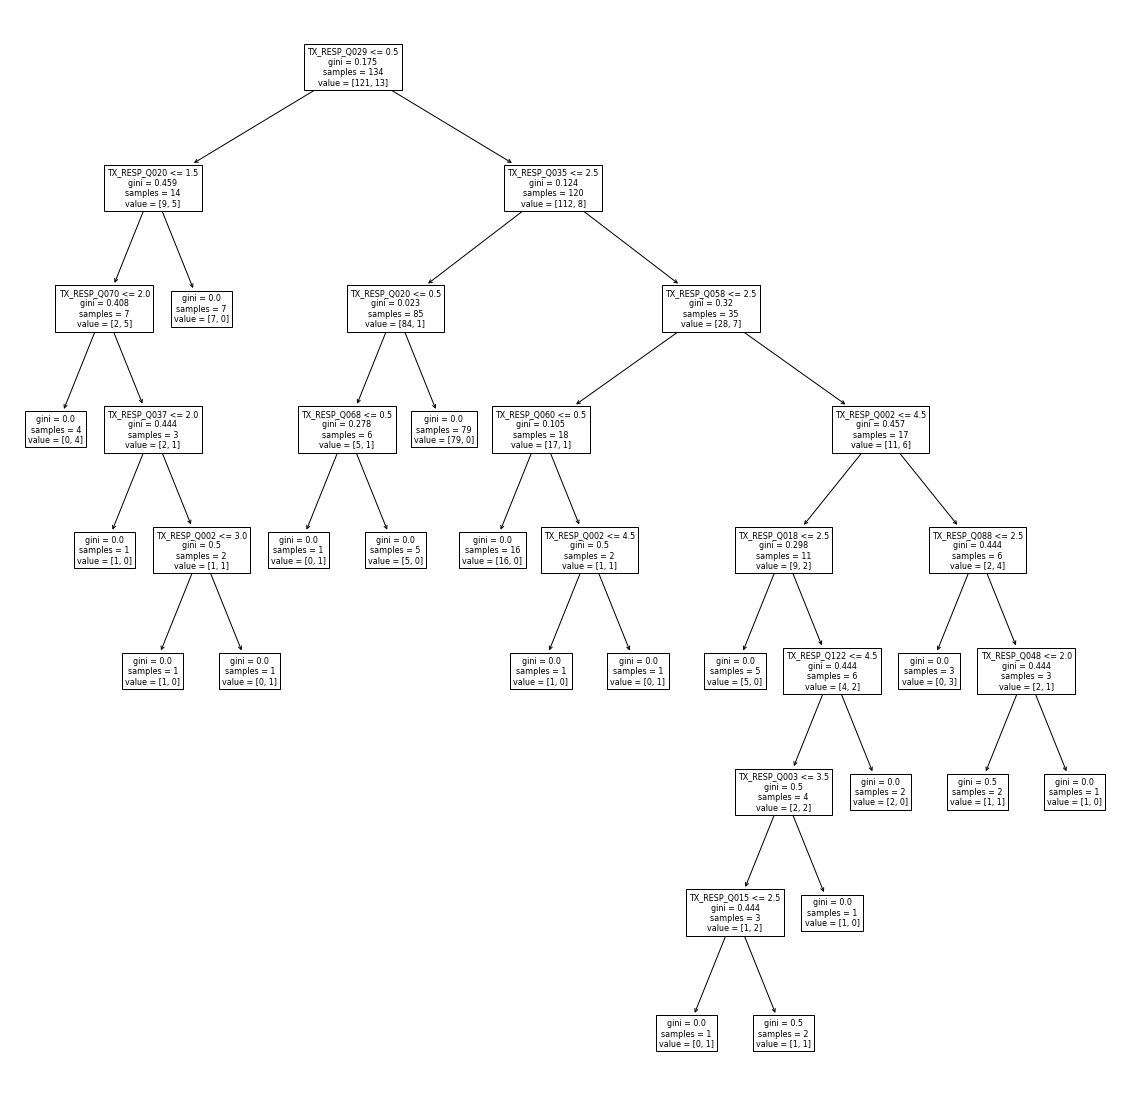

In [ ]:
# mostrando árvore
plt.figure(figsize=(20, 20)) 
plot_tree(classificador,feature_names=X.columns)
plt.show()

['TX_RESP_Q029',
 'TX_RESP_Q020',
 'TX_RESP_Q070',
 'TX_RESP_Q037',
 'TX_RESP_Q002',
 'TX_RESP_Q035',
 'TX_RESP_Q020',
 'TX_RESP_Q068',
 'TX_RESP_Q058',
 'TX_RESP_Q060',
 'TX_RESP_Q002',
 'TX_RESP_Q002',
 'TX_RESP_Q018',
 'TX_RESP_Q122',
 'TX_RESP_Q003',
 'TX_RESP_Q015',
 'TX_RESP_Q088',
 'TX_RESP_Q048']

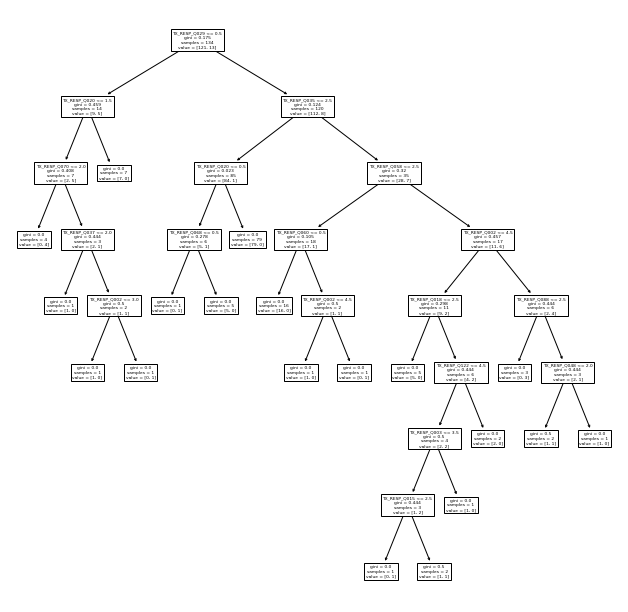

In [ ]:
# script para pegar as features selecionadas para a árvore
questoes = []
for informacoes in plot_tree(classificador,feature_names=X.columns):
  no = str(informacoes).split()[2].replace("'", '')
  if no[0] == 'T':
    questoes.append(no)
questoes

In [ ]:
# mostrando questões escolhidas
for coluna in questoes:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q029
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Acessibilidade
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q020
------------------------------
NESTE ANO, O QUE NORMALMENTE VOCÊ TEM FEITO QUANDO ESTÁ FORA DO(S) SEU(S) LOCAL(IS) DE TRABALHO? - Participo de festas da comunidade (igreja, bairro etc.)
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q070
------------------------------
NESTE ANO, INDIQUE O PRINCIPAL RESPONSÁVEL PELAS SEGUINTES DEFINIÇÕES: - Metodologia de ensino
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q037
------------------------------
INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA NESTA ESCOLA E QUAL A SUA ADEQUAÇÃO PARA AS ATIVIDADES EM SALA DE AULA: - Internet
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q002
------------------------------

In [ ]:
# mostrando tabela com informações das questões escolhidas
resultados = []
for coluna in questoes:
  resultados.append(pegar_informacoes_questao(coluna))
  resultados.append(questoes_contagem[questoes_contagem['questão'] == coluna])
pd.concat(resultados)

,questão,descrição,A,B,C,D,E,F,G
28,TX_RESP_Q029,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
28,TX_RESP_Q029,NaN,20,19,41,112,0,0,0
19,TX_RESP_Q020,"NESTE ANO, O QUE NORMALMENTE VOCÊ TEM FEITO QU...",Nunca.,Poucas vezes.,Muitas vezes.,Sempre.,NaN,NaN,NaN
19,TX_RESP_Q020,NaN,9,71,58,54,0,0,0
69,TX_RESP_Q070,"NESTE ANO, INDIQUE O PRINCIPAL RESPONSÁVEL PEL...",Docente da turma.,Todo o corpo docente da escola.,Equipe gestora.,Decisão externa à escola (Secretaria de Educaç...,NaN,NaN,NaN
69,TX_RESP_Q070,NaN,88,56,16,32,0,0,0
36,TX_RESP_Q037,INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA N...,NÃO USO / Não tem.,USO E É Inadequado.,USO E É Pouco adequado.,USO E É Razoavelmente adequado.,USO E É Adequado.,NaN,NaN
36,TX_RESP_Q037,NaN,47,17,35,54,39,0,0
1,TX_RESP_Q002,Há quantos anos você trabalha como professor (a)?,Meu primeiro ano.,1-2 anos.,3-5 anos.,6-10 anos.,11-15 anos.,16-20 anos.,Mais de 20 anos.
1,TX_RESP_Q002,NaN,7,8,9,29,38,36,65


In [ ]:
# salvando resultados
questoes_selecionadas.append(questoes)

## Wrapper Forward Selection

Fontes:

https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

https://heartbeat.fritz.ai/hands-on-with-feature-selection-techniques-wrapper-methods-5bb6d99b1274

Irei usar a métrica F1-score junto com Random Forest para avaliar o Wrapper Forward.

In [ ]:
# separando X e y
X = dados_filtrados.drop(columns=['ID_LOCALIZACAO', 'ID_SERIE', 'IDEB2019', 'classe'])
y = dados_filtrados['classe']

In [ ]:
# cria o forward selection e seus parâmetros
forward_selection = SequentialFeatureSelector(RandomForestClassifier(), 
           k_features=15, # serão selecionados 15 questões (número arbitrário)
           forward=True,  # estratégia forward
           scoring='f1', # usarei f1  score como métrica
           cv=4# folders de cross validation para evitar viés
           )

In [ ]:
# treinando forward 
forward_selection = forward_selection.fit(X, y)

In [ ]:
# printando as features selecionadas
selected_features = X.columns[list(forward_selection.k_feature_idx_)]
print(selected_features)

# printando o f1-escore final
print(forward_selection.k_score_)

Index(['TX_RESP_Q021', 'TX_RESP_Q029', 'TX_RESP_Q032', 'TX_RESP_Q050',
       'TX_RESP_Q061', 'TX_RESP_Q066', 'TX_RESP_Q077', 'TX_RESP_Q079',
       'TX_RESP_Q084', 'TX_RESP_Q091', 'TX_RESP_Q103', 'TX_RESP_Q104',
       'TX_RESP_Q107', 'TX_RESP_Q111', 'TX_RESP_Q124'],
      dtype='object')
0.2916666666666667


In [ ]:
# mostrando questões escolhidas
for coluna in selected_features:
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q021
------------------------------
NESTE ANO, O QUE NORMALMENTE VOCÊ TEM FEITO QUANDO ESTÁ FORA DO(S) SEU(S) LOCAL(IS) DE TRABALHO? - Estudo
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q029
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Acessibilidade
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q032
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Lousa (quadro de giz ou quadro branco)
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q050
------------------------------
EM QUE MEDIDA VOCÊ SE SENTE PREPARADO(A) PARA AS SEGUINTES ATIVIDADES: - Utilizar conhecimentos sobre o desenvolvimento da aprendizagem
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q061
----------------------

In [ ]:
# mostrando tabela com informações das questões escolhidas
resultados = []
for coluna in selected_features:
  resultados.append(pegar_informacoes_questao(coluna))
  resultados.append(questoes_contagem[questoes_contagem['questão'] == coluna])
pd.concat(resultados)

,questão,descrição,A,B,C,D,E,F,G
20,TX_RESP_Q021,"NESTE ANO, O QUE NORMALMENTE VOCÊ TEM FEITO QU...",Nunca.,Poucas vezes.,Muitas vezes.,Sempre.,NaN,NaN,NaN
20,TX_RESP_Q021,NaN,1,12,77,102,0,0,0
28,TX_RESP_Q029,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
28,TX_RESP_Q029,NaN,20,19,41,112,0,0,0
31,TX_RESP_Q032,AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ U...,Inadequado.,Pouco adequado.,Razoavelmente adequado.,Adequado.,NaN,NaN,NaN
31,TX_RESP_Q032,NaN,15,20,41,116,0,0,0
49,TX_RESP_Q050,EM QUE MEDIDA VOCÊ SE SENTE PREPARADO(A) PARA ...,Nada preparado(a).,Pouco preparado(a).,Razoavelmente preparado(a).,Muito preparado(a).,NaN,NaN,NaN
49,TX_RESP_Q050,NaN,0,3,57,132,0,0,0
60,TX_RESP_Q061,"DURANTE ESTE ANO, INDIQUE DE QUAIS CURSOS DE P...",Não fiz este curso.,"Sim, sem apoio.","Sim, com apoio parcial.","Sim, com apoio total.",NaN,NaN,NaN
60,TX_RESP_Q061,NaN,188,1,2,1,0,0,0


In [ ]:
# passando selecionados para wrapper
questoes_selecionadas.append(list(selected_features))

## Merge

In [ ]:
# mostrando quantidade de técnicas de questões selecionadas
len(questoes_selecionadas)

5

In [ ]:
questoes_selecionadas

[['TX_RESP_Q002',
  'TX_RESP_Q037',
  'TX_RESP_Q098',
  'TX_RESP_Q060',
  'TX_RESP_Q092',
  'TX_RESP_Q097',
  'TX_RESP_Q122',
  'TX_RESP_Q034',
  'TX_RESP_Q019',
  'TX_RESP_Q085',
  'TX_RESP_Q028',
  'TX_RESP_Q095',
  'TX_RESP_Q111',
  'TX_RESP_Q091',
  'TX_RESP_Q006',
  'TX_RESP_Q120',
  'TX_RESP_Q036',
  'TX_RESP_Q003',
  'TX_RESP_Q029',
  'TX_RESP_Q101',
  'TX_RESP_Q072',
  'TX_RESP_Q024',
  'TX_RESP_Q023'],
 ['TX_RESP_Q106',
  'TX_RESP_Q100',
  'TX_RESP_Q107',
  'TX_RESP_Q108',
  'TX_RESP_Q105',
  'TX_RESP_Q102',
  'TX_RESP_Q061',
  'TX_RESP_Q060',
  'TX_RESP_Q101',
  'TX_RESP_Q103',
  'TX_RESP_Q104',
  'TX_RESP_Q079',
  'TX_RESP_Q078',
  'TX_RESP_Q077',
  'TX_RESP_Q005',
  'TX_RESP_Q109',
  'TX_RESP_Q115',
  'TX_RESP_Q076',
  'TX_RESP_Q075',
  'TX_RESP_Q099'],
 ['TX_RESP_Q037',
  'TX_RESP_Q029',
  'TX_RESP_Q095',
  'TX_RESP_Q063',
  'TX_RESP_Q067',
  'TX_RESP_Q092',
  'TX_RESP_Q062',
  'TX_RESP_Q091',
  'TX_RESP_Q056',
  'TX_RESP_Q111',
  'TX_RESP_Q040',
  'TX_RESP_Q003',
  'TX_RE

In [ ]:
# script para contar quantas vezes determinada questão apareceu
pontuacao = dict()
for tecnica in questoes_selecionadas:
  for questao in tecnica:
    if questao not in pontuacao:
      pontuacao[questao] = 0
    pontuacao[questao] += 1 
pontuacao

{'TX_RESP_Q002': 4,
 'TX_RESP_Q003': 3,
 'TX_RESP_Q005': 2,
 'TX_RESP_Q006': 1,
 'TX_RESP_Q013': 1,
 'TX_RESP_Q015': 1,
 'TX_RESP_Q018': 1,
 'TX_RESP_Q019': 1,
 'TX_RESP_Q020': 2,
 'TX_RESP_Q021': 1,
 'TX_RESP_Q023': 1,
 'TX_RESP_Q024': 2,
 'TX_RESP_Q027': 1,
 'TX_RESP_Q028': 2,
 'TX_RESP_Q029': 4,
 'TX_RESP_Q032': 1,
 'TX_RESP_Q034': 1,
 'TX_RESP_Q035': 1,
 'TX_RESP_Q036': 1,
 'TX_RESP_Q037': 3,
 'TX_RESP_Q040': 1,
 'TX_RESP_Q048': 1,
 'TX_RESP_Q050': 1,
 'TX_RESP_Q056': 1,
 'TX_RESP_Q058': 2,
 'TX_RESP_Q060': 3,
 'TX_RESP_Q061': 2,
 'TX_RESP_Q062': 1,
 'TX_RESP_Q063': 1,
 'TX_RESP_Q066': 1,
 'TX_RESP_Q067': 1,
 'TX_RESP_Q068': 1,
 'TX_RESP_Q070': 1,
 'TX_RESP_Q072': 1,
 'TX_RESP_Q075': 1,
 'TX_RESP_Q076': 1,
 'TX_RESP_Q077': 2,
 'TX_RESP_Q078': 1,
 'TX_RESP_Q079': 2,
 'TX_RESP_Q084': 1,
 'TX_RESP_Q085': 1,
 'TX_RESP_Q088': 1,
 'TX_RESP_Q091': 3,
 'TX_RESP_Q092': 2,
 'TX_RESP_Q095': 2,
 'TX_RESP_Q096': 1,
 'TX_RESP_Q097': 1,
 'TX_RESP_Q098': 2,
 'TX_RESP_Q099': 1,
 'TX_RESP_Q100': 1,


In [ ]:
# passando valores para tupla
# fazendo isso é possível a ordenação dos valors

questoes = []
for questao in pontuacao:
  questoes.append((questao, pontuacao[questao]))

# mostrando  as 10 primeiras questoes
questoes[:10]

[('TX_RESP_Q002', 4),
 ('TX_RESP_Q037', 3),
 ('TX_RESP_Q098', 2),
 ('TX_RESP_Q060', 3),
 ('TX_RESP_Q092', 2),
 ('TX_RESP_Q097', 1),
 ('TX_RESP_Q122', 2),
 ('TX_RESP_Q034', 1),
 ('TX_RESP_Q019', 1),
 ('TX_RESP_Q085', 1)]

In [ ]:
pontuacao

{'TX_RESP_Q002': 4,
 'TX_RESP_Q003': 3,
 'TX_RESP_Q005': 2,
 'TX_RESP_Q006': 1,
 'TX_RESP_Q013': 1,
 'TX_RESP_Q015': 1,
 'TX_RESP_Q018': 1,
 'TX_RESP_Q019': 1,
 'TX_RESP_Q020': 2,
 'TX_RESP_Q021': 1,
 'TX_RESP_Q023': 1,
 'TX_RESP_Q024': 2,
 'TX_RESP_Q027': 1,
 'TX_RESP_Q028': 2,
 'TX_RESP_Q029': 4,
 'TX_RESP_Q032': 1,
 'TX_RESP_Q034': 1,
 'TX_RESP_Q035': 1,
 'TX_RESP_Q036': 1,
 'TX_RESP_Q037': 3,
 'TX_RESP_Q040': 1,
 'TX_RESP_Q048': 1,
 'TX_RESP_Q050': 1,
 'TX_RESP_Q056': 1,
 'TX_RESP_Q058': 2,
 'TX_RESP_Q060': 3,
 'TX_RESP_Q061': 2,
 'TX_RESP_Q062': 1,
 'TX_RESP_Q063': 1,
 'TX_RESP_Q066': 1,
 'TX_RESP_Q067': 1,
 'TX_RESP_Q068': 1,
 'TX_RESP_Q070': 1,
 'TX_RESP_Q072': 1,
 'TX_RESP_Q075': 1,
 'TX_RESP_Q076': 1,
 'TX_RESP_Q077': 2,
 'TX_RESP_Q078': 1,
 'TX_RESP_Q079': 2,
 'TX_RESP_Q084': 1,
 'TX_RESP_Q085': 1,
 'TX_RESP_Q088': 1,
 'TX_RESP_Q091': 3,
 'TX_RESP_Q092': 2,
 'TX_RESP_Q095': 2,
 'TX_RESP_Q096': 1,
 'TX_RESP_Q097': 1,
 'TX_RESP_Q098': 2,
 'TX_RESP_Q099': 1,
 'TX_RESP_Q100': 1,


In [ ]:
questoes = shell_sort(questoes)
questoes.reverse()
questoes

[('TX_RESP_Q029', 4),
 ('TX_RESP_Q002', 4),
 ('TX_RESP_Q037', 3),
 ('TX_RESP_Q111', 3),
 ('TX_RESP_Q003', 3),
 ('TX_RESP_Q060', 3),
 ('TX_RESP_Q091', 3),
 ('TX_RESP_Q122', 2),
 ('TX_RESP_Q101', 2),
 ('TX_RESP_Q077', 2),
 ('TX_RESP_Q005', 2),
 ('TX_RESP_Q098', 2),
 ('TX_RESP_Q104', 2),
 ('TX_RESP_Q020', 2),
 ('TX_RESP_Q061', 2),
 ('TX_RESP_Q024', 2),
 ('TX_RESP_Q058', 2),
 ('TX_RESP_Q092', 2),
 ('TX_RESP_Q107', 2),
 ('TX_RESP_Q079', 2),
 ('TX_RESP_Q095', 2),
 ('TX_RESP_Q103', 2),
 ('TX_RESP_Q028', 2),
 ('TX_RESP_Q096', 1),
 ('TX_RESP_Q124', 1),
 ('TX_RESP_Q021', 1),
 ('TX_RESP_Q032', 1),
 ('TX_RESP_Q088', 1),
 ('TX_RESP_Q048', 1),
 ('TX_RESP_Q018', 1),
 ('TX_RESP_Q068', 1),
 ('TX_RESP_Q084', 1),
 ('TX_RESP_Q109', 1),
 ('TX_RESP_Q015', 1),
 ('TX_RESP_Q013', 1),
 ('TX_RESP_Q102', 1),
 ('TX_RESP_Q105', 1),
 ('TX_RESP_Q027', 1),
 ('TX_RESP_Q040', 1),
 ('TX_RESP_Q056', 1),
 ('TX_RESP_Q062', 1),
 ('TX_RESP_Q067', 1),
 ('TX_RESP_Q066', 1),
 ('TX_RESP_Q050', 1),
 ('TX_RESP_Q075', 1),
 ('TX_RESP

Fazer a seleção de acordo com o número de pontuação

In [ ]:
# mostrando as 15 questões que mais aparecem
for questao in questoes[:15]:
  coluna = questao[0]
  print('=-='*10)
  print(coluna)
  print('---'*10)
  print(list(pegar_informacoes_questao(coluna)['descrição'])[0])
  print('=-='*10)
  print()

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q029
------------------------------
AVALIE AS CONDIÇÕES DA SALA DE AULA QUE VOCÊ UTILIZA NESTA ESCOLA COM RELAÇÃO AOS SEGUINTES ELEMENTOS: - Acessibilidade
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q002
------------------------------
Há quantos anos você trabalha como professor (a)?
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q037
------------------------------
INDIQUE OS RECURSOS QUE VOCÊ NORMALMENTE USA NESTA ESCOLA E QUAL A SUA ADEQUAÇÃO PARA AS ATIVIDADES EM SALA DE AULA: - Internet
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q111
------------------------------
INDIQUE A FREQUÊNCIA COM QUE VOCÊ DESENVOLVE AS SEGUINTES PRÁTICAS PEDAGÓGICAS NESTA TURMA: - Corrigir com os(as) alunos(as) o dever de casa
=-==-==-==-==-==-==-==-==-==-=

=-==-==-==-==-==-==-==-==-==-=
TX_RESP_Q003
------------------------------
Há quantos anos você trabalha como professor(a) nesta esco

In [ ]:
# pegando features selecionadas
feature_selecionadas = []
for questao in questoes[:15]:
  feature_selecionadas.append(questao[0])
feature_selecionadas

['TX_RESP_Q029',
 'TX_RESP_Q002',
 'TX_RESP_Q037',
 'TX_RESP_Q111',
 'TX_RESP_Q003',
 'TX_RESP_Q060',
 'TX_RESP_Q091',
 'TX_RESP_Q122',
 'TX_RESP_Q101',
 'TX_RESP_Q077',
 'TX_RESP_Q005',
 'TX_RESP_Q098',
 'TX_RESP_Q104',
 'TX_RESP_Q020',
 'TX_RESP_Q061']

# Criando nova base de dados

In [ ]:
# mostrando features para nova base de dados
feature_selecionadas

['TX_RESP_Q029',
 'TX_RESP_Q002',
 'TX_RESP_Q037',
 'TX_RESP_Q111',
 'TX_RESP_Q003',
 'TX_RESP_Q060',
 'TX_RESP_Q091',
 'TX_RESP_Q122',
 'TX_RESP_Q101',
 'TX_RESP_Q077',
 'TX_RESP_Q005',
 'TX_RESP_Q098',
 'TX_RESP_Q104',
 'TX_RESP_Q020',
 'TX_RESP_Q061']

In [ ]:
# mostrando novo dataframe
novos_dados = dados_filtrados[feature_selecionadas + ['classe']]
novos_dados.head()

,TX_RESP_Q029,TX_RESP_Q002,TX_RESP_Q037,TX_RESP_Q111,TX_RESP_Q003,TX_RESP_Q060,TX_RESP_Q091,TX_RESP_Q122,TX_RESP_Q101,TX_RESP_Q077,TX_RESP_Q005,TX_RESP_Q098,TX_RESP_Q104,TX_RESP_Q020,TX_RESP_Q061,classe
0,0.0,6.0,1.0,5.0,5.0,0.0,2.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,1
1,3.0,5.0,2.0,4.0,3.0,0.0,2.0,5.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0
3,0.0,4.0,3.0,5.0,4.0,0.0,2.0,5.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,1
4,3.0,6.0,4.0,5.0,6.0,0.0,3.0,4.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0,1
5,0.0,4.0,3.0,5.0,2.0,0.0,2.0,4.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1


OS dados parecem extremamente desbalanceados (problema de classificação binária pesando muito pra uma classe) isso pode atrapalhar na construção dos modelos (como errar estatísticas de recall e precision score). Dados assim podem dar a sensação de false bom desempenho, tendo em vista que se os dados tem, por exemplo, 90% das instâncias de um tipo de classe e os outros 10% de outra, basta o modelo apontar todas as instâncias como sendo das de 90%, fazendo isso a acurácia vai ser de 90% e isso está completamente errado.

# Analisando novos dados

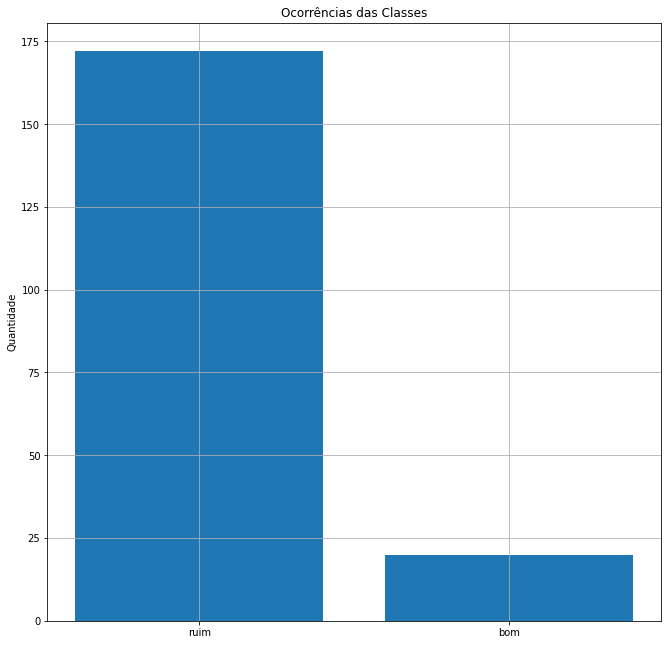

ruim: 172 | bom: 20


In [ ]:
# verificando se classe estão balanceadas

classes = novos_dados.groupby(by=['classe'])['classe'].count()

plt.bar(['ruim', 'bom'], [classes[0], classes[1]])
plt.ylabel('Quantidade')
plt.title('Ocorrências das Classes')
plt.grid(True)
plt.show()

print('ruim: {} | bom: {}'.format(classes[0], classes[1]))



As classes estão extremamente desbalanceadas, mais ou menos 88% de diferença entre a classe ruim e bom.

Classes desbalanceadas podem comprometer o resultado dos algoritmos, podendo ocorrer desde resultados ilusoriamente bons a totalmente ruins.

Possíveis soluções para desbalanceamento de dados:

*   Triplicar o número de instâncias da classe bom.
*   Deixar a classe ruim com o mesmo número de instâncias que a bom após trilicar.



# Balanceando dados

In [ ]:
len(novos_dados.columns)

16

In [ ]:
# separando dados

inst_ruins = novos_dados[novos_dados.classe == 0]
inst_boas = novos_dados[novos_dados.classe == 1]

X = novos_dados.drop(columns=['classe'])
y = novos_dados.classe

In [ ]:
print('Número de instâncias com ideb insatisfatório:', len(inst_ruins))
print('Número de instâncias com ideb satisfatório:', len(inst_boas))

Número de instâncias com ideb insatisfatório: 172
Número de instâncias com ideb satisfatório: 20


In [ ]:
# balanceando dados
X_balanceado, y_balanceado = SMOTE().fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Script para juntar em um dataframe os dados que foram balanceados
dados_balanceados = []
for i in range(len(y_balanceado)):
  linha = list(X_balanceado[i])
  linha.append(y_balanceado[i])
  dados_balanceados.append(linha)
dados_balanceados = pd.DataFrame(dados_balanceados, columns=novos_dados.columns)
dados_balanceados.head()


,TX_RESP_Q029,TX_RESP_Q002,TX_RESP_Q037,TX_RESP_Q111,TX_RESP_Q003,TX_RESP_Q060,TX_RESP_Q091,TX_RESP_Q122,TX_RESP_Q101,TX_RESP_Q077,TX_RESP_Q005,TX_RESP_Q098,TX_RESP_Q104,TX_RESP_Q020,TX_RESP_Q061,classe
0,0.0,6.0,1.0,5.0,5.0,0.0,2.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,1
1,3.0,5.0,2.0,4.0,3.0,0.0,2.0,5.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0
2,0.0,4.0,3.0,5.0,4.0,0.0,2.0,5.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,1
3,3.0,6.0,4.0,5.0,6.0,0.0,3.0,4.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0,1
4,0.0,4.0,3.0,5.0,2.0,0.0,2.0,4.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1


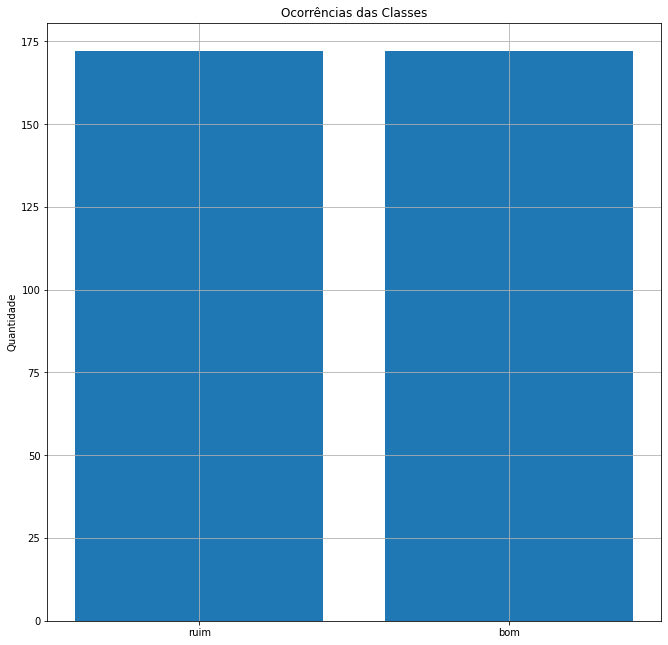

ruim: 172 | bom: 172


In [ ]:
# mostrando que as classes estão balanceadas

classes = dados_balanceados.groupby(by=['classe'])['classe'].count()

plt.bar(['ruim', 'bom'], [classes[0], classes[1]])
plt.ylabel('Quantidade')
plt.title('Ocorrências das Classes')
plt.grid(True)
plt.show()

print('ruim: {} | bom: {}'.format(classes[0], classes[1]))


# Testando modelos

## Preparando dados

In [ ]:
X = dados_balanceados.drop(columns=['classe'])
y = dados_balanceados['classe']

In [ ]:
# 20% dos dados serão para teste 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

## Random Forest

In [ ]:
# definindo e treinando random forest com 150 árvores
floresta = RandomForestClassifier(n_estimators=150)
floresta.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# calculando o score da random forest
floresta.score(X_train, y_train)

0.9958333333333333

Usando dados para teste

In [ ]:
# realizando previsão com random forest
clf_floresta = floresta.predict(X_test)

Avaliando modelo

https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0

In [ ]:
print('Acurácia: ', accuracy_score(y_test,clf_floresta))
print('Precisão: ', precision_score(y_test, clf_floresta))
print('Recall: ', recall_score(y_test, clf_floresta))
print('F1-Score: ', f1_score(y_test,clf_floresta))

Acurácia:  0.9134615384615384
Precisão:  0.9777777777777777
Recall:  0.8461538461538461
F1-Score:  0.9072164948453608


## Árvore de decisão

In [ ]:
# definindo modelo de árvore de decisão 
arvore = DecisionTreeClassifier()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

In [ ]:
print('Acurácia: ', accuracy_score(y_test,pred_arvore))
print('Precisão: ', precision_score(y_test, pred_arvore))
print('Recall: ', recall_score(y_test, pred_arvore))
print('F1-Score: ', f1_score(y_test,pred_arvore))

Acurácia:  0.8846153846153846
Precisão:  0.9545454545454546
Recall:  0.8076923076923077
F1-Score:  0.875


## SVM

In [ ]:
# definindo modelo SVM
svm = SVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)

In [ ]:
print('Acurácia: ', accuracy_score(y_test,pred_svm))
print('Precisão: ', precision_score(y_test, pred_svm))
print('Recall: ', recall_score(y_test, pred_svm))
print('F1-Score: ', f1_score(y_test,pred_svm))

Acurácia:  0.8557692307692307
Precisão:  0.8135593220338984
Recall:  0.9230769230769231
F1-Score:  0.8648648648648649


## Kmeans

In [ ]:
# definindo modelo Kmeans
kmeans = KMeans()
kmeans.fit(X_train, y_train)
pred_kmeans = kmeans.predict(X_test)

In [ ]:
# só é possível medir a acurácia com algoritmos de agrupamento
print('Acurácia: ', accuracy_score(y_test,pred_kmeans))

Acurácia:  0.11538461538461539


## RP-TREE

## Vou fazer o J48 enquanto você faz a correção. Estou fazendo aqui na minha máquina.



a) Processo CRISP-DM 
1. analise de dados e limpeza
2. seleção de atributos
3. criação de um metodo 
 com estrutura de ordençação e média e mediana
da ocorrencia dos atributos
4. classificação de o ideb por meios de algoritmos regra, arvore e svm.
5.  Aplicação do método de avaliação estatística de Friedman e Nemenyi no R para comparar as saídas dos classificadores.
6. preditor com front-end em stremlite


Segue link do arquivo para próximos passos
https://www.br-ie.org/pub/index.php/sbie/article/view/8916

b) Identificação dos fatores de melhorias no IDEB pelo uso de mineração de dados: Um estudo de caso em escolas municipais de MACEIÓ

c) Segue dissertação para analise mais detalhes: http://www.repositorio.ufal.br/handle/riufal/7782

Nosso alvo é criar um preditor no final de todo o processo. Para front-end usaremos o Streamlite  segue link https://streamlit.io/gallery


1 - Henrique Seleção de Atributos: Correlação, Qui-Quadrado, SymmetricalUncertAttributeEval, OneRAttributeEval, GainRatio AttributeEval. J48

2 - Glevson Seleção de Atributos: ReliefFAttributeEval, WrapperSubsetEval com o NaiveBayes; REPTree, InfoGain-AttributeEval.


In [ ]:
# Importando as bibliotecas necessárias:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

Definição: A árvore de Decisão é um tipo de algoritmo de aprendizagem de máquina supervisionado que se baseia na ideia de divisão dos dados em grupos homogêneos, podem ser utilizadas em um cenário de classificação ou regressão. Por isso usamos também como algoritmo de seleção de atributos. A mesma também contem o calculo do ganho de informação em sua estrutura.

In [ ]:
#Vamos usar uma das métricas como: o Indice Gini, Chi-Square, Information Gain e a redução da variância. Para criar partições mais puras e encontrar os melhores atributos.